# Online Retail Clustering

Abstract: This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.

# Import Libraries

In [59]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime as dt, timedelta
import plotly.express as px
import plotly.graph_objects as go
import plotly.colors
import scipy.stats as stats
import os
# pd.options.display.float_format = '{:20.2f}'.format
# pd.set_option('display.max_columns', 999)

In [2]:
# Surpress warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# Load data

In [3]:
df = pd.read_excel('dataset/Online Retail.xlsx', sheet_name='Online Retail')

# Data Exploration

In [6]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [8]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.00,541909,541909.00,406829.00
mean,9.55,2011-07-04 13:34:57.156386048,4.61,15287.69
min,-80995.00,2010-12-01 08:26:00,-11062.06,12346.00
25%,1.00,2011-03-28 11:34:00,1.25,13953.00
50%,3.00,2011-07-19 17:17:00,2.08,15152.00
75%,10.00,2011-10-19 11:27:00,4.13,16791.00
max,80995.00,2011-12-09 12:50:00,38970.00,18287.00
std,218.08,NaN,96.76,1713.60


In [9]:
df.describe(include='O')

,InvoiceNo,StockCode,Description,Country
count,541909,541909,540455,541909
unique,25900,4070,4223,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
freq,1114,2313,2369,495478


# Verifying Basic Data Integrity

## Customer ID

Customer ID has missing data, some of the transcations looks ligit.

In [4]:
df[df['CustomerID'].isna()].head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom
1447,536544,21790,VINTAGE SNAP CARDS,9,2010-12-01 14:32:00,1.66,NaN,United Kingdom
1448,536544,21791,VINTAGE HEADS AND TAILS CARD GAME,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1449,536544,21801,CHRISTMAS TREE DECORATION WITH BELL,10,2010-12-01 14:32:00,0.43,NaN,United Kingdom
1450,536544,21802,CHRISTMAS TREE HEART DECORATION,9,2010-12-01 14:32:00,0.43,NaN,United Kingdom
1451,536544,21803,CHRISTMAS TREE STAR DECORATION,11,2010-12-01 14:32:00,0.43,NaN,United Kingdom


## Checking for negative quantiy

It appears that negative quantity is for cancelled transaction. This will need to be dealt with in the data cleaning stage

In [5]:
df[df['Quantity'] < 0].head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2010-12-01 10:24:00,3.45,17548.0,United Kingdom
240,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
939,C536506,22960,JAM MAKING SET WITH JARS,-6,2010-12-01 12:38:00,4.25,17897.0,United Kingdom


## Invoice Number

InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation

In [6]:
df['InvoiceNo'] = df['InvoiceNo'].astype("str")
df[df['InvoiceNo'].str.match('^\\d{6}$') == False]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


In [7]:
df['InvoiceNo'].str.replace('[0-9]', "", regex = True).unique()

array(['', 'C', 'A'], dtype=object)

In [8]:
df[df['InvoiceNo'].str.startswith('A')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,NaN,United Kingdom
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


## Stock Code

StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product

In [9]:
df['StockCode'] = df['StockCode'].astype("str")
df[(df['StockCode'].str.match('^\\d{5}$') == False) & (df['StockCode'].str.match('^\\d{5}[a-zA-Z]+$') == False)]['StockCode'].unique()

array(['POST', 'D', 'C2', 'DOT', 'M', 'BANK CHARGES', 'S', 'AMAZONFEE',
       'DCGS0076', 'DCGS0003', 'gift_0001_40', 'DCGS0070', 'm',
       'gift_0001_50', 'gift_0001_30', 'gift_0001_20', 'DCGS0055',
       'DCGS0072', 'DCGS0074', 'DCGS0069', 'DCGS0057', 'DCGSSBOY',
       'DCGSSGIRL', 'gift_0001_10', 'PADS', 'DCGS0004', 'DCGS0073',
       'DCGS0071', 'DCGS0068', 'DCGS0067', 'DCGS0066P', 'B', 'CRUK'],
      dtype=object)

In [44]:
# df[df['StockCode'].str.contains('^CRUK')]

In [ ]:
# To remove
# 'DOT', C2, D, M or m, BANK CHARGES or B, S, AMAZONFEE, gift_XXX, CRUK

# Data Cleaning

In [10]:
cleaned_df = df.copy()

In [11]:
cleaned_df['InvoiceNo'] = cleaned_df['InvoiceNo'].astype("str")

mask =(
    cleaned_df['InvoiceNo'].str.match('^\\d{6}$') == True
)

cleaned_df = cleaned_df[mask]

cleaned_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [12]:
cleaned_df['StockCode'] = cleaned_df['StockCode'].astype("str")

mask =(
    (cleaned_df['StockCode'].str.match('^\\d{5}$') == True)
    | (cleaned_df['StockCode'].str.match('^\\d{5}[a-zA-Z]+$') == True)
    | (cleaned_df['StockCode'].str.match('^PADS$') == True)
)

cleaned_df = cleaned_df[mask]

cleaned_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [13]:
cleaned_df.dropna(subset=['CustomerID'], inplace=True)

In [14]:
cleaned_df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,396374.000000,396374,396374.000000,396374.000000
mean,13.046353,2011-07-11 00:04:48.847805440,2.867954,15301.603824
min,1.000000,2010-12-01 08:26:00,0.000000,12346.000000
25%,2.000000,2011-04-07 11:16:00,1.250000,13975.000000
50%,6.000000,2011-07-31 14:39:00,1.950000,15159.000000
75%,12.000000,2011-10-20 14:41:00,3.750000,16803.000000
max,80995.000000,2011-12-09 12:50:00,649.500000,18287.000000
std,180.732689,NaN,4.264554,1709.976485


In [15]:
len(cleaned_df[cleaned_df['UnitPrice'] == 0])

34

In [16]:
mean_unit_price = cleaned_df['UnitPrice'].mean()

cleaned_df['UnitPrice'] = cleaned_df['UnitPrice'].replace(0, mean_unit_price)

In [17]:
cleaned_df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,396374.000000,396374,396374.000000,396374.000000
mean,13.046353,2011-07-11 00:04:48.847805440,2.868200,15301.603824
min,1.000000,2010-12-01 08:26:00,0.001000,12346.000000
25%,2.000000,2011-04-07 11:16:00,1.250000,13975.000000
50%,6.000000,2011-07-31 14:39:00,1.950000,15159.000000
75%,12.000000,2011-10-20 14:41:00,3.750000,16803.000000
max,80995.000000,2011-12-09 12:50:00,649.500000,18287.000000
std,180.732689,NaN,4.264471,1709.976485


In [18]:
cleaned_df['UnitPrice'].min()

0.001

In [19]:
len(cleaned_df)/len(df)

0.7314401495454034

# Feature Engineering

In [20]:
cleaned_df['SalesLineTotal'] = cleaned_df['Quantity'] * cleaned_df['UnitPrice']
cleaned_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,SalesLineTotal
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [21]:
reference_date = cleaned_df['InvoiceDate'].max()

In [22]:
reference_date

Timestamp('2011-12-09 12:50:00')

In [23]:
aggregated_df = cleaned_df.groupby('CustomerID', as_index=False) \
.agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'SalesLineTotal': 'sum'
})

In [24]:
aggregated_df.rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'SalesLineTotal': 'MonetaryValue'}, inplace=True)

In [25]:
aggregated_df.head()

,CustomerID,Recency,Frequency,MonetaryValue
0,12346.0,325,1,77183.60
1,12347.0,1,7,4310.00
2,12348.0,74,4,1437.24
3,12349.0,18,1,1457.55
4,12350.0,309,1,294.40


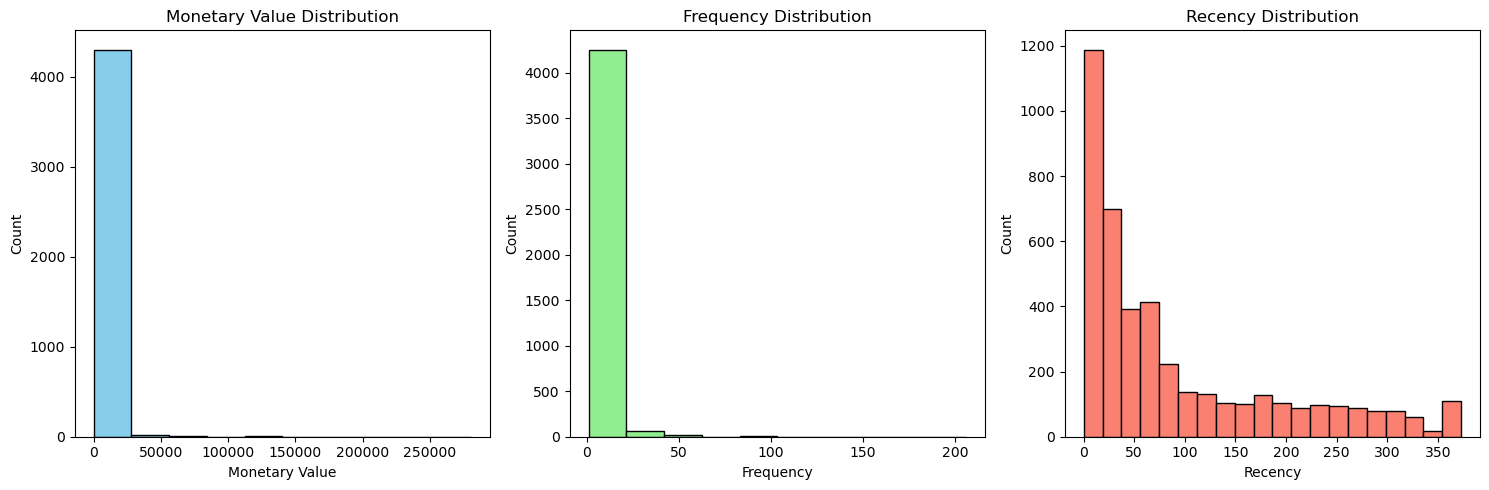

In [26]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(aggregated_df['MonetaryValue'], bins=10, color='skyblue', edgecolor='black')
plt.title('Monetary Value Distribution')
plt.xlabel('Monetary Value')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
plt.hist(aggregated_df['Frequency'], bins=10, color='lightgreen', edgecolor='black')
plt.title('Frequency Distribution')
plt.xlabel('Frequency')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
plt.hist(aggregated_df['Recency'], bins=20, color='salmon', edgecolor='black')
plt.title('Recency Distribution')
plt.xlabel('Recency')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

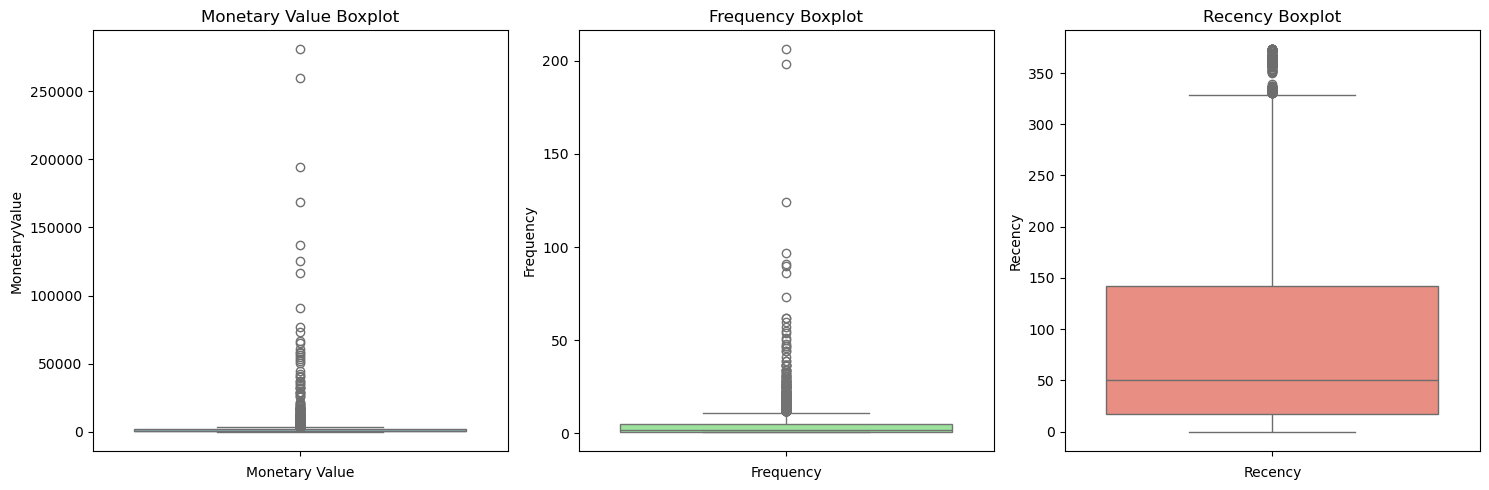

In [27]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(aggregated_df['MonetaryValue'], color='skyblue')
plt.title('Monetary Value Boxplot')
plt.xlabel('Monetary Value')

plt.subplot(1, 3, 2)
sns.boxplot(aggregated_df['Frequency'], color='lightgreen')
plt.title('Frequency Boxplot')
plt.xlabel('Frequency')

plt.subplot(1, 3, 3)
sns.boxplot(aggregated_df['Recency'], color='salmon')
plt.title('Recency Boxplot')
plt.xlabel('Recency')

plt.tight_layout()
plt.show()

# Dealing with outliers

In [28]:
M_Q1 = aggregated_df['MonetaryValue'].quantile(0.25)
M_Q3 = aggregated_df['MonetaryValue'].quantile(0.75)
M_IQR = M_Q3 - M_Q1

monetary_outliers_df = aggregated_df[(aggregated_df['MonetaryValue'] > (M_Q3 + 1.5 * M_IQR)) | 
(aggregated_df['MonetaryValue'] < (M_Q1 - 1.5*M_IQR))].copy()

In [29]:
monetary_outliers_df.describe()

,CustomerID,Recency,Frequency,MonetaryValue
count,425.000000,425.000000,425.000000,425.000000
mean,15023.480000,24.738824,16.607059,12652.536867
std,1795.657929,47.071954,19.088633,26175.673690
min,12346.000000,0.000000,1.000000,3627.770000
25%,13319.000000,3.000000,8.000000,4366.780000
50%,14961.000000,10.000000,12.000000,5898.420000
75%,16652.000000,23.000000,19.000000,9585.910000
max,18251.000000,371.000000,206.000000,280789.961626


In [30]:
M_Q1 = aggregated_df['Frequency'].quantile(0.25)
M_Q3 = aggregated_df['Frequency'].quantile(0.75)
M_IQR = M_Q3 - M_Q1

frequency_outliers_df = aggregated_df[(aggregated_df['Frequency'] > (M_Q3 + 1.5 * M_IQR)) | 
(aggregated_df['Frequency'] < (M_Q1 - 1.5*M_IQR))].copy()

frequency_outliers_df.describe()

,CustomerID,Recency,Frequency,MonetaryValue
count,278.000000,278.000000,278.000000,278.000000
mean,15355.669065,13.165468,23.093525,14499.942745
std,1745.001840,30.366616,21.175012,30216.842989
min,12395.000000,0.000000,12.000000,1296.440000
25%,13880.250000,2.000000,13.000000,4199.206477
50%,15290.500000,5.500000,17.000000,6283.525000
75%,16781.250000,15.000000,25.000000,11040.835000
max,18283.000000,371.000000,206.000000,280789.961626


In [31]:
non_outliers_df = aggregated_df[(~aggregated_df.index.isin(monetary_outliers_df.index)) &
(~aggregated_df.index.isin(frequency_outliers_df.index))
]

non_outliers_df.describe()

,CustomerID,Recency,Frequency,MonetaryValue
count,3863.000000,3863.000000,3863.000000,3863.000000
mean,15323.852705,99.943826,2.755371,853.879007
std,1709.731704,101.866688,2.168332,794.606720
min,12348.000000,0.000000,1.000000,3.750000
25%,13850.500000,21.000000,1.000000,278.500000
50%,15333.000000,58.000000,2.000000,570.460000
75%,16798.000000,160.000000,4.000000,1187.005000
max,18287.000000,373.000000,11.000000,3619.170000


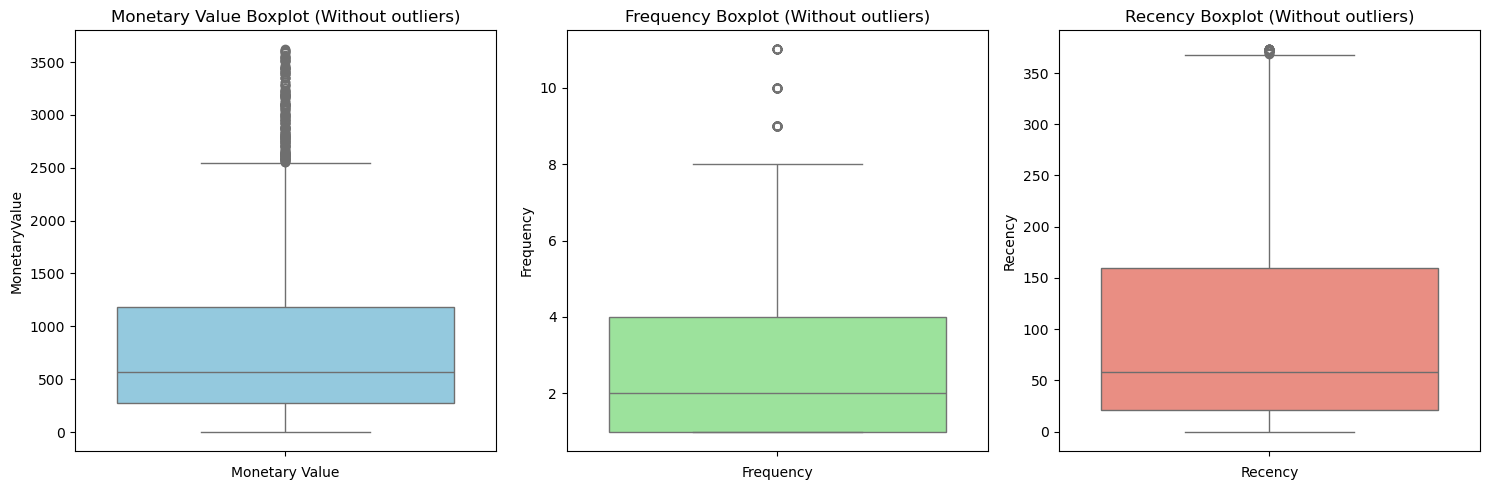

In [32]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(non_outliers_df['MonetaryValue'], color='skyblue')
plt.title('Monetary Value Boxplot (Without outliers)')
plt.xlabel('Monetary Value')

plt.subplot(1, 3, 2)
sns.boxplot(non_outliers_df['Frequency'], color='lightgreen')
plt.title('Frequency Boxplot (Without outliers)')
plt.xlabel('Frequency')

plt.subplot(1, 3, 3)
sns.boxplot(non_outliers_df['Recency'], color='salmon')
plt.title('Recency Boxplot (Without outliers)')
plt.xlabel('Recency')

plt.tight_layout()
plt.show()

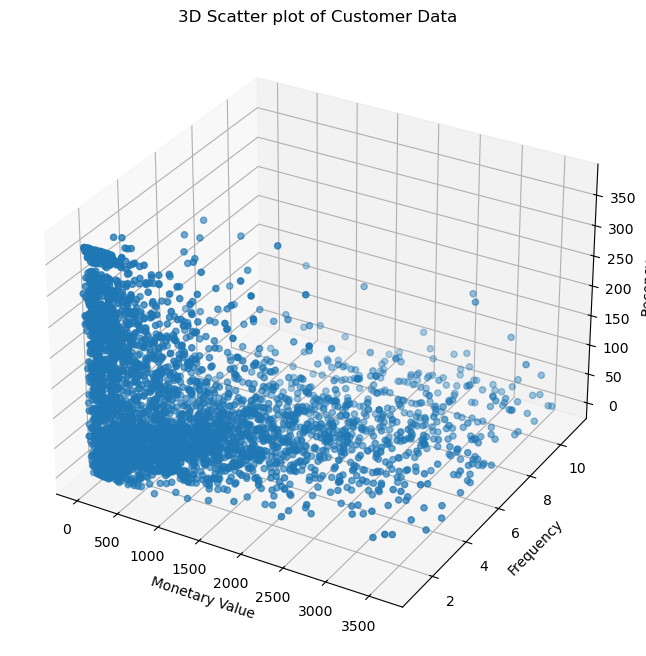

In [33]:
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(projection='3d')

scatter = ax.scatter(non_outliers_df['MonetaryValue'], non_outliers_df['Frequency'], non_outliers_df['Recency'])

ax.set_xlabel('Monetary Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

ax.set_title('3D Scatter plot of Customer Data')

plt.show()

# Data Scalling

In [36]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(non_outliers_df[['MonetaryValue', 'Frequency', 'Recency']])

scaled_data_df = pd.DataFrame(scaled_data, index=non_outliers_df.index, columns=('MonetaryValue', 'Frequency', 'Recency'))

scaled_data_df

,MonetaryValue,Frequency,Recency
2,0.734246,0.574077,-0.254717
3,0.759809,-0.809654,-0.804526
4,-0.704187,-0.809654,2.052518
5,0.669425,1.957808,-0.637620
6,-0.962713,-0.809654,1.011808
...,...,...,...
4329,-0.855854,-0.809654,-0.264535
4330,-0.847421,-0.809654,1.738342
4331,-0.973008,-0.809654,0.785993
4332,-0.850630,-0.348410,-0.912525


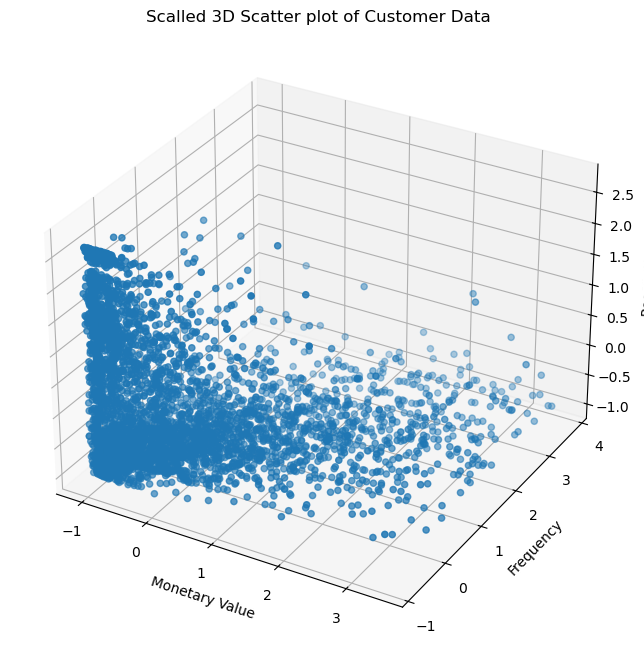

In [38]:
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(projection='3d')

scatter = ax.scatter(scaled_data_df['MonetaryValue'], scaled_data_df['Frequency'], scaled_data_df['Recency'])

ax.set_xlabel('Monetary Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

ax.set_title('Scalled 3D Scatter plot of Customer Data')

plt.show()

# KMeans Clustering

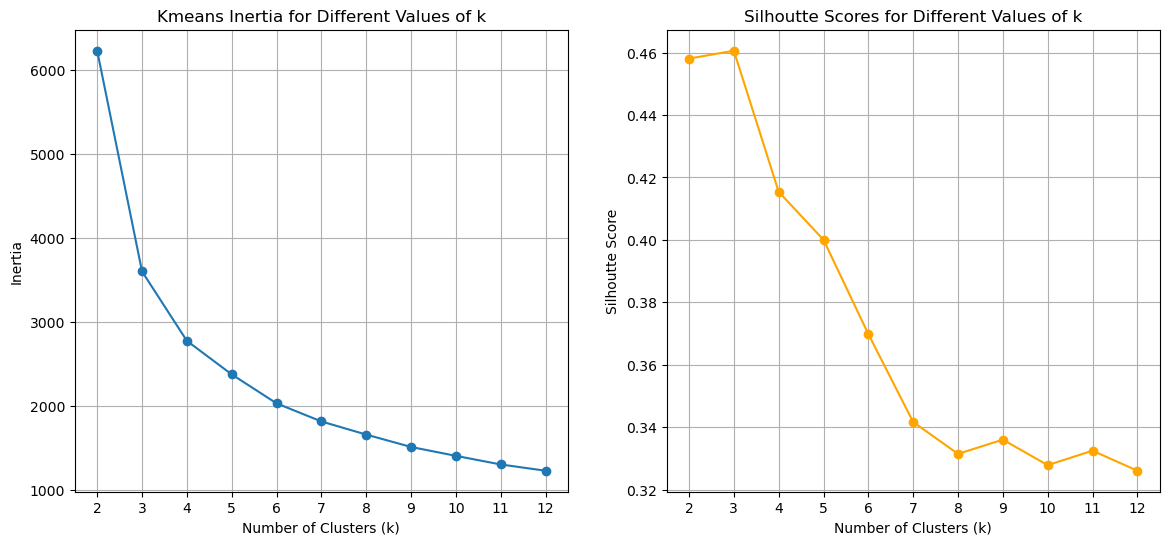

In [44]:
max_k = 12

inertia = []
silhoutte_scores = []
k_values = range(2, max_k + 1)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, max_iter=1000)
    cluster_labels = kmeans.fit_predict(scaled_data_df)
    
    sil_score = silhouette_score(scaled_data_df, cluster_labels)
    
    silhoutte_scores.append(sil_score)
    
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, marker = 'o')
plt.title('Kmeans Inertia for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_values, silhoutte_scores, marker = 'o', color='orange')
plt.title('Silhoutte Scores for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhoutte Score')
plt.xticks(k_values)
plt.grid(True)

plt.tight_layout
plt.show()

In [46]:
kmeans = KMeans(n_clusters=4, random_state=42, max_iter=1000)
cluster_labels = kmeans.fit_predict(scaled_data_df)

non_outliers_df['Clusters'] = cluster_labels

non_outliers_df

,CustomerID,Recency,Frequency,MonetaryValue,Clusters
2,12348.0,74,4,1437.24,3
3,12349.0,18,1,1457.55,0
4,12350.0,309,1,294.40,1
5,12352.0,35,7,1385.74,2
6,12353.0,203,1,89.00,1
...,...,...,...,...,...
4329,18278.0,73,1,173.90,0
4330,18280.0,277,1,180.60,1
4331,18281.0,180,1,80.82,1
4332,18282.0,7,2,178.05,0


In [47]:
non_outliers_df['Clusters'].value_counts()

Clusters
0    1549
1     942
3     890
2     482
Name: count, dtype: int64

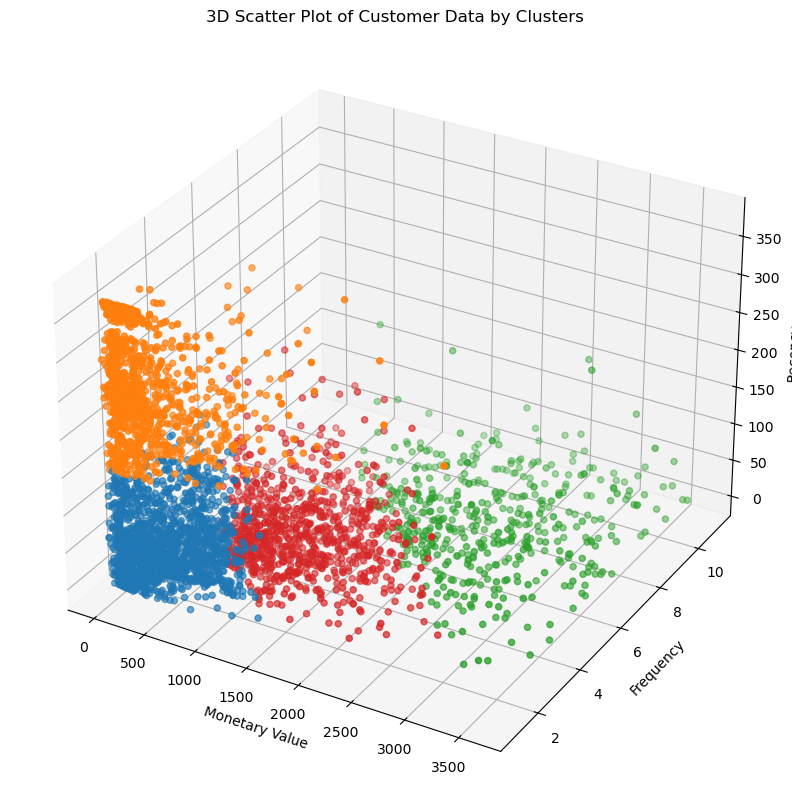

In [65]:
cluster_colors = {0:'#1f77b4', 
                  1:'#ff7f0e', 
                  2:'#2ca02c', 
                  3:'#d62728'}

colors = non_outliers_df['Clusters'].map(cluster_colors)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

scatter = ax.scatter(non_outliers_df['MonetaryValue'], 
                     non_outliers_df['Frequency'], 
                     non_outliers_df['Recency'], 
                     c=colors, marker='o')

ax.set_xlabel('Monetary Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

ax.set_title('3D Scatter Plot of Customer Data by Clusters')

plt.show()

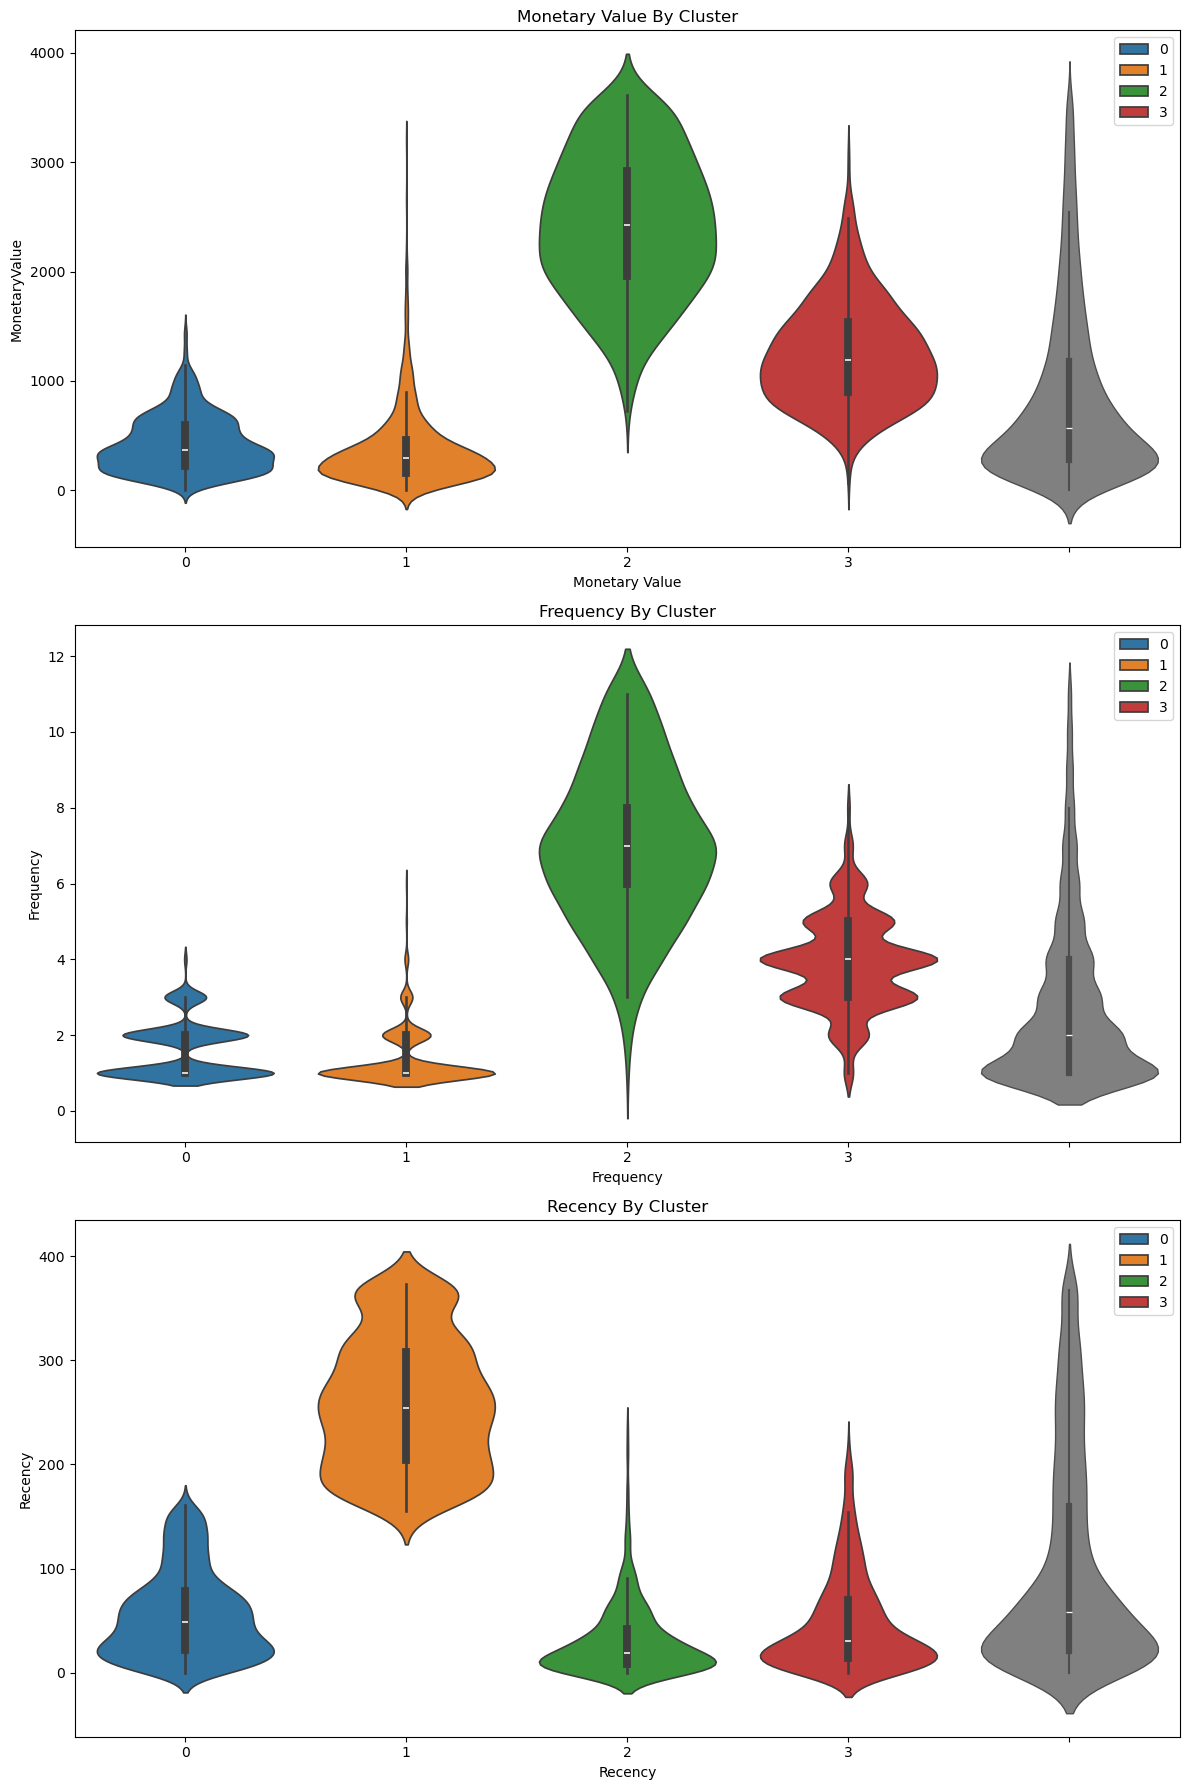

In [66]:
# Create the 'images' directory if it doesn't exist
if not os.path.exists('images'):
    os.makedirs('images')

plt.figure(figsize=(12, 18))

# Plot for Monetary Value
plt.subplot(3, 1, 1)
sns.violinplot(x=non_outliers_df['Clusters'], y=non_outliers_df['MonetaryValue'], palette=cluster_colors, hue=non_outliers_df['Clusters'])
sns.violinplot(y=non_outliers_df['MonetaryValue'], color='gray', linewidth=1.0)
plt.title('Monetary Value By Cluster')
plt.xlabel('Monetary Value')

# Plot for Frequency
plt.subplot(3, 1, 2)
sns.violinplot(x=non_outliers_df['Clusters'], y=non_outliers_df['Frequency'], palette=cluster_colors, hue=non_outliers_df['Clusters'])
sns.violinplot(y=non_outliers_df['Frequency'], color='gray', linewidth=1.0)
plt.title('Frequency By Cluster')
plt.xlabel('Frequency')

# Plot for Recency
plt.subplot(3, 1, 3)
sns.violinplot(x=non_outliers_df['Clusters'], y=non_outliers_df['Recency'], palette=cluster_colors, hue=non_outliers_df['Clusters'])
sns.violinplot(y=non_outliers_df['Recency'], color='gray', linewidth=1.0)
plt.title('Recency By Cluster')
plt.xlabel('Recency')
plt.savefig('images/violinplots.png')

plt.tight_layout()
plt.show()

Cluster 0 (Blue): "Re-engage"

**Rationale:** The combination of lower monetary value, frequency, and recency suggests that Cluster 0 consists of less engaged customers who are not contributing significantly to sales. This cluster might represent a segment that requires more attention to boost their engagement and spending.

**Action:** Personalized Re-engagement Campaigns: Send personalized emails or messages with special offers tailored to their past purchases. Highlight new products or services that might interest them. Exclusive Discounts: Offer exclusive discounts or limited-time promotions to incentivize them to make a purchase. Customer Surveys: Conduct surveys to understand their needs and preferences better. Use this feedback to improve your offerings and communication strategies.

Cluster 1 (Orange): "Nurture"

**Rationale:** The combination of slightly lower monetary value and frequency, but higher recency, suggests that Cluster 1 consists of recently engaged customers who have potential but are not yet fully contributing to sales. This cluster might benefit from nurturing strategies to increase their spending and purchase frequency.

**Action:** Loyalty Programs: Introduce or enhance loyalty programs that reward frequent purchases. Offer points, discounts, or exclusive access to new products. Personalized Recommendations: Use data-driven insights to recommend products based on their purchase history. Highlight items that complement their previous purchases. Engaging Content: Create engaging content such as blog posts, videos, or social media updates that resonate with their interests and encourage them to stay connected with your brand.

Cluster 2 (Green): "Retain"

**Rationale:** The combination of higher monetary value and frequency, but lower recency, suggests that Cluster 2 consists of high-value customers who have not made recent purchases. This cluster represents a valuable segment at risk of churning and requires retention strategies to bring them back and maintain their engagement.

**Action:** VIP Treatment: Offer VIP treatment with exclusive benefits such as early access to sales, special discounts, or personalized services. Make them feel valued and appreciated. Re-engagement Offers: Send personalized re-engagement offers with significant discounts or special deals to entice them back. Feedback and Improvement: Reach out to these customers to understand why they haven\'t purchased recently. Use their feedback to address any issues and improve their experience.

Cluster 3 (Red): "Maintain"

**Rationale:** The combination of higher monetary value and frequency, but lower recency, suggests that Cluster 3 consists of moderately high-value customers who are somewhat engaged but have not made very recent purchases. This cluster might benefit from strategies to maintain their engagement and spending levels.

 **Action:** Regular Updates: Keep these customers engaged with regular updates about new products, upcoming sales, and special events. Use personalized communication to make them feel valued. Special Promotions: Offer special promotions or discounts to encourage them to make a purchase. Highlight the benefits of acting quickly to take advantage of these deals. Enhanced Customer Experience: Focus on enhancing the overall customer experience by providing excellent customer service, personalized support, and a seamless shopping experience.

# Outlier Data

In [55]:
Overlap_indices = monetary_outliers_df.index.intersection(frequency_outliers_df.index)

monetary_only_outliers = monetary_outliers_df.drop(Overlap_indices)
frequency_only_outliers = frequency_outliers_df.drop(Overlap_indices)
monetary_and_frequency_outliers = monetary_outliers_df.loc[Overlap_indices]

monetary_only_outliers['Clusters'] = -1
frequency_only_outliers['Clusters'] = -2
monetary_and_frequency_outliers['Clusters'] = -3

outliers_cluster_df = pd.concat([monetary_only_outliers, frequency_only_outliers, monetary_and_frequency_outliers])

outliers_cluster_df

,CustomerID,Recency,Frequency,MonetaryValue,Clusters
0,12346.0,325,1,77183.60,-1
1,12347.0,1,7,4310.00,-1
10,12357.0,32,1,6207.67,-1
12,12359.0,57,4,6372.58,-1
15,12362.0,2,10,4737.23,-1
...,...,...,...,...,...
4249,18172.0,14,20,7561.68,-3
4269,18198.0,3,17,5425.56,-3
4288,18223.0,4,14,6484.54,-3
4290,18225.0,2,12,5509.12,-3


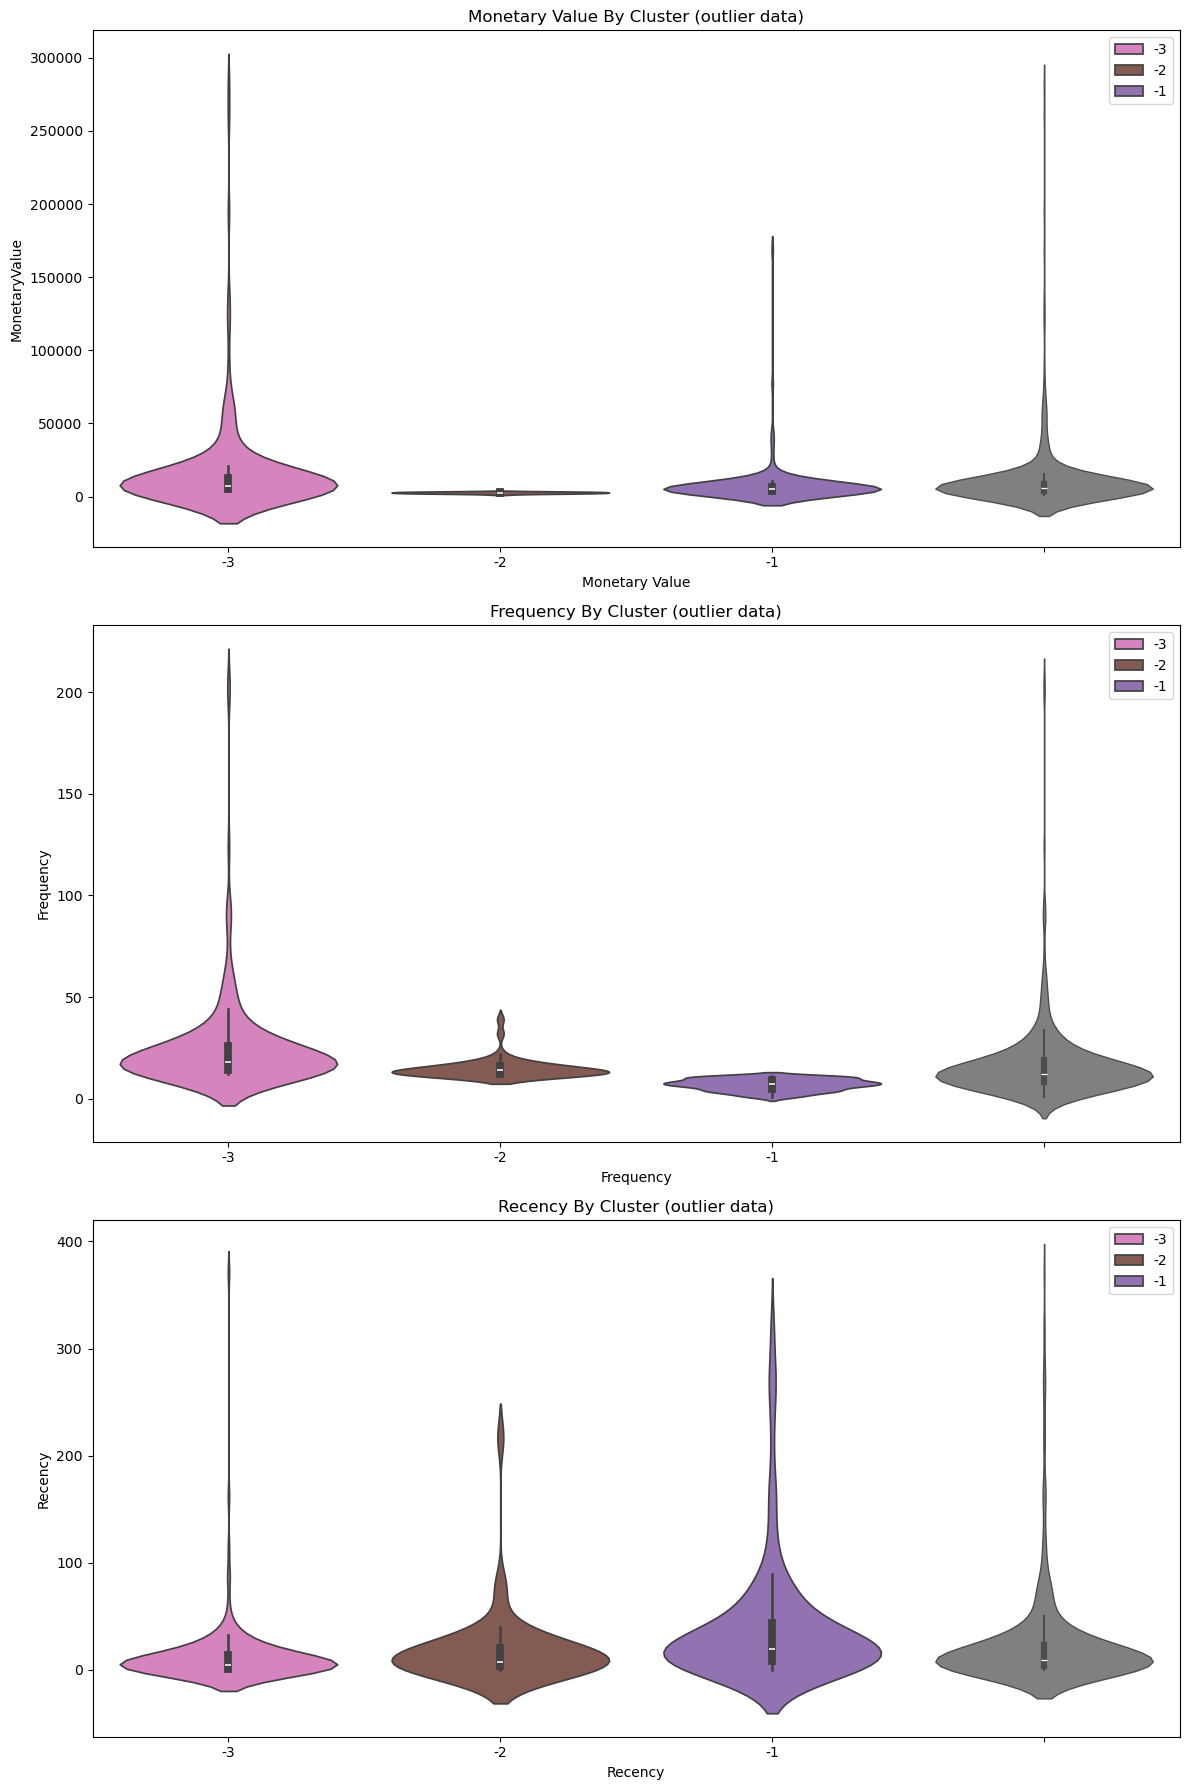

In [63]:
cluster_colors = {-1:'#9467bd', 
                  -2:'#8c564b', 
                  -3:'#e377c2'}

plt.figure(figsize=(12, 18))

plt.subplot(3, 1, 1)
sns.violinplot(x=outliers_cluster_df['Clusters'], y=outliers_cluster_df['MonetaryValue'], palette=cluster_colors, hue=outliers_cluster_df['Clusters'])
sns.violinplot(y=outliers_cluster_df['MonetaryValue'], color='gray', linewidth=1.0)
plt.title('Monetary Value By Cluster (outlier data)')
plt.xlabel('Monetary Value')

plt.subplot(3, 1, 2)
sns.violinplot(x=outliers_cluster_df['Clusters'], y=outliers_cluster_df['Frequency'], palette=cluster_colors, hue=outliers_cluster_df['Clusters'])
sns.violinplot(y=outliers_cluster_df['Frequency'], color='gray', linewidth=1.0)
plt.title('Frequency By Cluster (outlier data)')
plt.xlabel('Frequency')

plt.subplot(3, 1, 3)
sns.violinplot(x=outliers_cluster_df['Clusters'], y=outliers_cluster_df['Recency'], palette=cluster_colors, hue=outliers_cluster_df['Clusters'])
sns.violinplot(y=outliers_cluster_df['Recency'], color='gray', linewidth=1.0)
plt.title('Recency By Cluster (outlier data)')
plt.xlabel('Recency')

plt.tight_layout()
plt.show()

- Cluster -1 (Monetary Outliers) Pamper: Characteristics: High spenders but not necessarily frequent buyers. Their purchases are large but infrequent. Potential Strategy: Focus on maintaning their loyalty with personalised offers or luxury services that cater to their high spending capacity.

- Cluster -2 (frequent Outliers) Upsell: Characteristcs: Frequent buyers who spend less per purchase. These customers are consistently enegaged but might benefit gtom upselling opportunities. Potential strategy: Implement loyalty programs or bundle deals to encourage higher spending per visit, given their frequent engagement.

- Cluster -3 (Monetary and Frequency Outliers) Delight: Characteristics: The most valuable outliers, with extreme spending and frequent purchases. They are likely your top-tier customers who require special attention. Potential Strategy: Develop VIP programs or exclusive offers to maintain their loyalty and ecncourage continued engagement.

In [68]:
cluster_labels = {
    0: 'Re-engage',
    1: 'Nurture',
    2: 'Retain',
    3: 'Maintain',
    -1: 'Pampers',
    -2: 'Upsell',
    -3: 'Delight'
}

full_clustering_df = pd.concat([non_outliers_df, outliers_cluster_df])

full_clustering_df['ClusterLabel'] = full_clustering_df['Clusters'].map(cluster_labels)

full_clustering_df

,CustomerID,Recency,Frequency,MonetaryValue,Clusters,ClusterLabel
2,12348.0,74,4,1437.24,3,Maintain
3,12349.0,18,1,1457.55,0,Re-engage
4,12350.0,309,1,294.40,1,Nurture
5,12352.0,35,7,1385.74,2,Retain
6,12353.0,203,1,89.00,1,Nurture
...,...,...,...,...,...,...
4249,18172.0,14,20,7561.68,-3,Delight
4269,18198.0,3,17,5425.56,-3,Delight
4288,18223.0,4,14,6484.54,-3,Delight
4290,18225.0,2,12,5509.12,-3,Delight


# Visualisation

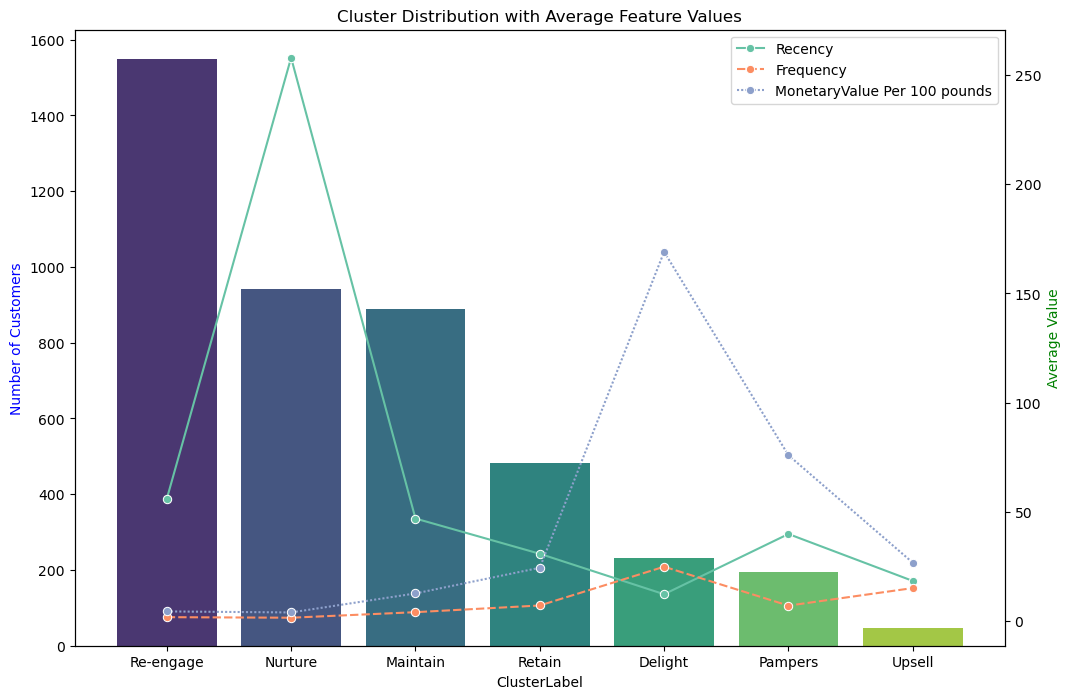

In [73]:
cluster_counts = full_clustering_df['ClusterLabel'].value_counts()
full_clustering_df['MonetaryValue Per 100 pounds'] = full_clustering_df['MonetaryValue']/100.00
feature_means = full_clustering_df.groupby('ClusterLabel')[['Recency', 'Frequency', 'MonetaryValue Per 100 pounds']].mean()

fig, ax1 = plt.subplots(figsize=(12, 8))

sns.barplot(x=cluster_counts.index, y=cluster_counts.values, ax=ax1, palette='viridis', hue=cluster_counts.index)
ax1.set_ylabel('Number of Customers', color='b')
ax1.set_title('Cluster Distribution with Average Feature Values')

ax2 = ax1.twinx()

sns.lineplot(data=feature_means, ax=ax2, palette='Set2', marker='o')
ax2.set_ylabel('Average Value', color='g')

plt.show()